This notebook contains code to extract features from the audio signals.

In [ ]:
import os
import pickle
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
import random
import pandas as pd
import IPython.display
import librosa.display
ms.use('seaborn-muted')
%matplotlib inline

In [2]:
data_dir = 'data/pre-processed/'
labels_df_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_1.pkl'.format(data_dir)

In [3]:
labels_df = pd.read_csv(labels_df_path)
audio_vectors = pickle.load(open(audio_vectors_path, 'rb'))

In [4]:
random_file_name = list(audio_vectors.keys())[random.choice(range(len(audio_vectors.keys())))]
y = audio_vectors[random_file_name]
sr = 44100

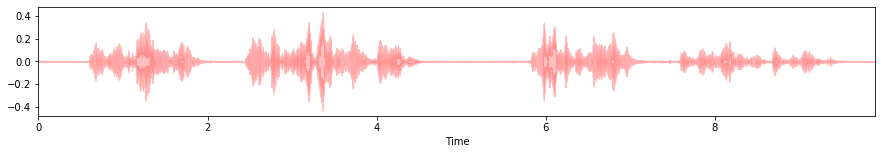

In [5]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(y, sr=sr, max_sr=1000, alpha=0.25, color='r')

In [6]:
print('Signal mean = {:.5f}'.format(np.mean(abs(y))))
print('Signal std dev = {:.5f}'.format(np.std(y)))

Signal mean = 0.02728
Signal std dev = 0.04852


RMSE mean = 0.03340
RMSE std dev = 0.03519


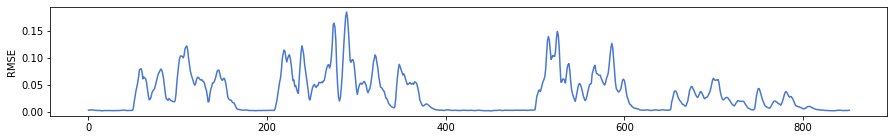

In [7]:
rmse = librosa.feature.rmse(y + 0.0001)[0]
plt.figure(figsize=(15,2))
plt.plot(rmse)
plt.ylabel('RMSE')
print('RMSE mean = {:.5f}'.format(np.mean(rmse)))
print('RMSE std dev = {:.5f}'.format(np.std(rmse)))

In [8]:
from IPython.display import Audio
Audio(y, rate=44100)

In [9]:
silence = 0
for e in rmse:
    if e <= 0.4 * np.mean(rmse):
        silence += 1
print(silence/float(len(rmse)))

0.4232121922626026


In [10]:
y_harmonic, y_percussive = librosa.effects.hpss(y)
np.mean(y_harmonic)

-6.231684e-06

In [11]:
autocorr = librosa.core.autocorrelate(y)
np.max(autocorr)

1028.015

In [ ]:
cl = 0.45 * np.mean(abs(y))
center_clipped = []
for s in y:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
np.max(new_autocorr)

In [ ]:
columns = ['wav_file', 'label', 'sig_mean', 'sig_std', 'rmse_mean', 'rmse_std', 'silence', 'harmonic', 'auto_corr_max', 'auto_corr_std']
df_features = pd.DataFrame(columns=columns)

The following blocks build feature vectors for all the files

In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 8}

data_dir = 'data/pre-processed/'
labels_path = '{}df_iemocap.csv'.format(data_dir)
audio_vectors_path = '{}audio_vectors_'.format(data_dir)

In [ ]:
labels_df = pd.read_csv(labels_path)

for sess in [1]:
        print(sess)
        audio_vectors = pickle.load(open('{}{}.pkl'.format(audio_vectors_path, sess), 'rb'))
        for index, row in tqdm(labels_df[labels_df['wav_file'].str.contains('Ses0{}'.format(sess))].iterrows()):
            try:
                wav_file_name = row['wav_file']
                label = emotion_dict[row['emotion']]
                y = audio_vectors[wav_file_name]

                feature_list = [wav_file_name, label]  # wav_file, label
                sig_mean = np.mean(abs(y))
                feature_list.append(sig_mean)  # sig_mean
                feature_list.append(np.std(y))  # sig_std

                rmse = librosa.feature.rms(y + 0.0001)[0]
                feature_list.append(np.mean(rmse))  # rmse_mean
                feature_list.append(np.std(rmse))  # rmse_std

                silence = 0
                for e in rmse:
                    if e <= 0.4 * np.mean(rmse):
                        silence += 1
                silence /= float(len(rmse))
                feature_list.append(silence)  # silence

                y_harmonic = librosa.effects.hpss(y)[0]
                feature_list.append(np.mean(y_harmonic) * 1000)  # harmonic (scaled by 1000)

                # based on the pitch detection algorithm mentioned here:
                # http://access.feld.cvut.cz/view.php?cisloclanku=2009060001
                cl = 0.45 * sig_mean
                center_clipped = []
                for s in y:
                    if s >= cl:
                        center_clipped.append(s - cl)
                    elif s <= -cl:
                        center_clipped.append(s + cl)
                    elif np.abs(s) < cl:
                        center_clipped.append(0)
                auto_corrs = librosa.core.autocorrelate(np.array(center_clipped))
                feature_list.append(1000 * np.max(auto_corrs)/len(auto_corrs))  # auto_corr_max (scaled by 1000)
                feature_list.append(np.std(auto_corrs))  # auto_corr_std

                df_features = df_features.append(pd.DataFrame(feature_list, index=columns).transpose(), ignore_index=True)
            except:
                print('Some exception occured')

    df_features.to_csv('data/pre-processed/audio_features_{}.csv'.format(sess), index=False)

1


120it [1:08:25, 77.42s/it] 